# Introduction 

# Enhancing Literature Exploration through Sequential Sentence Classification

When researchers delve into the vast expanse of previous literature, they often embark on a quest through abstracts. This quest serves the purpose of swiftly determining whether the papers align with their specific criteria of interest. The efficacy of this process is notably augmented when abstracts exhibit a structured format.

Structured abstracts, where the text is organized into semantic headings like objective, method, result, and conclusion, facilitate a more streamlined comprehension. However, a substantial challenge surfaces when a noteworthy portion of published paper abstracts remains unstructured. The absence of a predefined structure makes it more arduous to swiftly access pertinent information.

## The Significance of Sequential Sentence Classification

Recognizing this challenge, the concept of classifying each sentence within an abstract to an appropriate heading has emerged as a pivotal solution. This systematic classification not only contributes significantly to expediting the retrieval of desired information but also serves as a cornerstone for minimizing the time invested in literature exploration.

We term this process the **sequential sentence classification task**, differentiating it from general text or sentence classification. The crux lies in considering contextual relationships, providing a nuanced approach to understanding the narrative within the abstract.

### Beyond Human Aid

Apart from its immediate benefits for researchers, this task extends its utility to various realms:

- **Automatic Text Summarization:** Streamlining the process of extracting key information from textual content.
  
- **Information Extraction:** Enhancing the extraction of valuable insights from diverse sources.
  
- **Information Retrieval:** Facilitating efficient retrieval of targeted information.

In essence, the sequential sentence classification task not only aids human researchers but also lays the groundwork for enhancing automation processes in diverse text-related domains.


## Notebook Objective

* The purpose of this notebook is to systematically analyze **each component of the architecture in isolation**, assessing the individual results they yield. Subsequently, we will proceed to implement the complete architecture to gain insights into its overall performance and observe the collective impact of its constituent parts.


![Image](img/architecture.png)


## Getting the data

In [1]:
# Read the csv files : train, val, test
import pandas as pd
train_df = pd.read_csv('../Data/Processed/train.csv')
val_df = pd.read_csv('../Data/Processed/val.csv')
test_df = pd.read_csv('../Data/Processed/test.csv')


In [21]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [3]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Preparing our data for deep sequence models

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [5]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

In [6]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

*  95% of the sentences in our training set have a length of 55 tokens or less.

In [7]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

E:\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [8]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

### Create text vectorizer

In [10]:
# Number of words in our vocabulary
max_tokens = 68000

In [11]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # Number of words in vocabulary
                                   output_sequence_length = 55) # desired output length of vectorized sequences


In [12]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [13]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
recently , a smartphone-assisted guide with high precision has been described .

Length of text: 12

Vectorized text:
[[ 1612     8 45318  2212     7   181  5330   139   167  1794     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [14]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [15]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [16]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                              output_dim = 128,
                              mask_zero = True,
                              name = "token_embdedding")

## Create datasets

## Prefetching Data in Machine Learning

In the realm of machine learning, prefetching data is a strategy employed to optimize the training pipeline. Prefetching involves loading and preparing data batches ahead of time, reducing the idle time during model training.

### Advantages of Prefetching:

1. **Reduced Training Time:** Prefetching allows the training process to overlap with data loading, minimizing the waiting time for the model to receive the next batch.

2. **Improved Resource Utilization:** By fetching data asynchronously, computational resources are utilized more efficiently. This is particularly beneficial when dealing with large datasets or when working with hardware accelerators.

3. **Enhanced Training Stability:** Continuous data streaming ensures a steady flow of input to the model, contributing to more stable and consistent training.

### Implementation:

In practice, frameworks like TensorFlow and PyTorch provide tools to implement prefetching. These tools enable the overlap of data loading with the model's computation, leading to a smoother training process.

### Example (TensorFlow):

```python
# Create a Dataset and apply prefetching
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model training with the prefetched dataset
model.fit(dataset, epochs=num_epochs)


![Image](img/prefetch.png)


In [17]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [18]:
# Turn the Tensorslice into prefetch batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [20]:
train_dataset.batch

<bound method DatasetV2.batch of <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>>

In [23]:
180040/32

5626.25

# Model 1: Baseline Model

```
Input (text) -> Tokenize -> Embedding -> LSTM -> Output (label probability)
```

In [30]:
# Build the model
inputs = layers.Input(shape = (1,), dtype = tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.LSTM(units = 64)(token_embeddings)

outputs = layers.Dense(5, activation = "softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

# Fit the model 
model_1_history = model_1.fit(train_dataset,
                             epochs = 5,
                             validation_data = valid_dataset)

Epoch 1/5
5627/5627 [==============================] - 171s 29ms/step - loss: 0.5786 - accuracy: 0.7842 - val_loss: 0.4965 - val_accuracy: 0.8193
Epoch 2/5
5627/5627 [==============================] - 159s 28ms/step - loss: 0.4055 - accuracy: 0.8532 - val_loss: 0.5173 - val_accuracy: 0.8173
Epoch 3/5
5627/5627 [==============================] - 159s 28ms/step - loss: 0.3042 - accuracy: 0.8933 - val_loss: 0.5635 - val_accuracy: 0.8141
Epoch 4/5
5627/5627 [==============================] - 159s 28ms/step - loss: 0.2253 - accuracy: 0.9230 - val_loss: 0.6409 - val_accuracy: 0.8084
Epoch 5/5
5627/5627 [==============================] - 160s 28ms/step - loss: 0.1651 - accuracy: 0.9450 - val_loss: 0.7618 - val_accuracy: 0.7978


<Axes: >

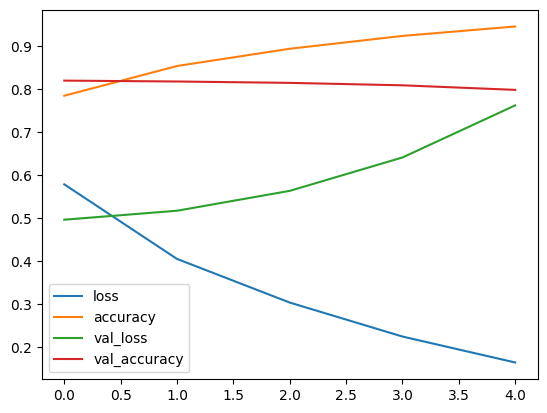

In [46]:
pd.DataFrame(model_1_history.history).plot()

# Model 2: Feature extraction with pretrained token embeddings

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> LSTM -> Output (prediction probabilities)
```

In [72]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [73]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
hr of t and r groups was increased immediately after re .

Sentence after embedding:
[ 0.00405522 -0.00013917  0.01433172  0.03807269 -0.06583429 -0.02935922
 -0.01105447 -0.06430527 -0.00820921  0.01838185  0.06163925  0.0032881
  0.02210326 -0.03467866  0.01379515  0.06180348 -0.01606528 -0.00657646
  0.02102998  0.07210676 -0.0594707   0.0711191  -0.07828455 -0.01020635
 -0.07718559  0.08391598 -0.06787936  0.01501799 -0.01528589 -0.05786846] (truncated output)...

Length of sentence embedding:
512


### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [77]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)# tokenize text and create embedding
print(pretrained_embedding.shape)
# Reshape the embedding to add a temporal dimension
reshaped_embedding = layers.Reshape((1, -1))(pretrained_embedding)
x = layers.LSTM(units = 64)(reshaped_embedding) 
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_2_history = model_2.fit(train_dataset,
            epochs = 5,
            validation_data = valid_dataset)

(None, 512)
Epoch 1/5
5627/5627 [==============================] - 159s 28ms/step - loss: 0.7633 - accuracy: 0.7066 - val_loss: 0.6855 - val_accuracy: 0.7387
Epoch 2/5
5627/5627 [==============================] - 155s 28ms/step - loss: 0.6654 - accuracy: 0.7466 - val_loss: 0.6449 - val_accuracy: 0.7542
Epoch 3/5
5627/5627 [==============================] - 155s 28ms/step - loss: 0.6325 - accuracy: 0.7595 - val_loss: 0.6236 - val_accuracy: 0.7627
Epoch 4/5
5627/5627 [==============================] - 154s 27ms/step - loss: 0.6100 - accuracy: 0.7680 - val_loss: 0.6092 - val_accuracy: 0.7678
Epoch 5/5
5627/5627 [==============================] - 155s 27ms/step - loss: 0.5921 - accuracy: 0.7752 - val_loss: 0.5991 - val_accuracy: 0.7722


<Axes: >

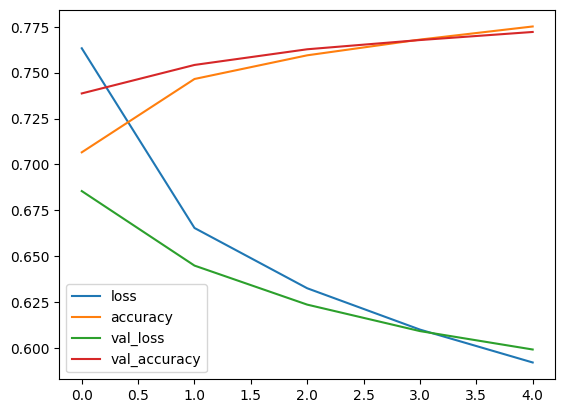

In [78]:
pd.DataFrame(model_2_history.history).plot()

In [79]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.5991 - accuracy: 0.7722


[0.5991313457489014, 0.7721766233444214]

In [80]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 18s 19ms/step


array([[5.34511030e-01, 3.74371886e-01, 1.34044298e-04, 8.86345059e-02,
        2.34851451e-03],
       [3.01237792e-01, 6.19607508e-01, 1.43738277e-03, 7.62611479e-02,
        1.45618315e-03],
       [5.72160006e-01, 1.49184670e-02, 2.40302179e-02, 3.81444722e-01,
        7.44661596e-03],
       ...,
       [3.96563933e-04, 2.60474859e-04, 1.39925452e-02, 1.03724116e-04,
        9.85246658e-01],
       [1.62288789e-02, 1.37138650e-01, 1.02141462e-01, 3.16306204e-03,
        7.41327941e-01],
       [1.07026435e-02, 9.84892130e-01, 3.91100952e-03, 1.02935053e-04,
        3.91358219e-04]], dtype=float32)

In [81]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1], dtype=int64)>

In [82]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.21766185621607,
 'precision': 0.7707093653825717,
 'recall': 0.7721766185621607,
 'f1': 0.7681057564282514}

# Model 3 : Character embeddings

In [84]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'h r   o f   t   a n d   r   g r o u p s   w a s   i n c r e a s e d   i m m e d i a t e l y   a f t e r   r e   .'

In [85]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


* Average character length

In [86]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

* Character length covers 95% of sequences


In [87]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

* Get all keyboard characters for char-level embedding

In [88]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [89]:
# Create char-level token vectorizer instance

# num characters in alphabet + space + OOV (out of vocabulary or unknown)
NUM_CHAR_TOKENS = len(alphabet) + 2 
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                   output_sequence_length = output_seq_char_len,
                                   standardize = "lower_and_strip_punctuation",
                                   name = "char_vectorizer") 

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [90]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [91]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
g r o u p s   w e r e   c o m p a r a b l e   w i t h   r e s p e c t   t o   s e x   ,   a g e   ,   r i s k   f a c t o r   a n d   e t i o l o g y   o f   t h e   s t r o k e   .

Length of chars: 74

Vectorized chars:
[[18  8  7 16 14  9 20  2  8  2 11  7 15 14  5  8  5 22 12  2 20  4  3 13
   8  2  9 14  2 11  3  3  7  9  2 24  5 18  2  8  4  9 23 17  5 11  3  7
   8  5  6 10  2  3  4  7 12  7 18 19  7 17  3 13  2  9  3  8  7 23  2  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0

### Create a character-level embedding

In [93]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character 
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")


In [94]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
g r o u p s   w e r e   c o m p a r a b l e   w i t h   r e s p e c t   t o   s e x   ,   a g e   ,   r i s k   f a c t o r   a n d   e t i o l o g y   o f   t h e   s t r o k e   .

Embedded chars (after vectorization and embedding):
[[[ 0.00394069  0.01645413 -0.00568391 ... -0.03391526  0.03727177
    0.03168298]
  [ 0.04800547 -0.005621   -0.02133815 ... -0.04307506  0.03475847
    0.03960195]
  [-0.01836275 -0.02959629  0.01092435 ...  0.01298387  0.02364745
    0.02485528]
  ...
  [-0.02208463  0.0192934   0.01557506 ...  0.01032665  0.04566652
    0.01998201]
  [-0.02208463  0.0192934   0.01557506 ...  0.01032665  0.04566652
    0.01998201]
  [-0.02208463  0.0192934   0.01557506 ...  0.01032665  0.04566652
    0.01998201]]]

Character embedding shape: (1, 290, 25)


### Model to fit on character embeddings

```
Input (character-level text) -> Tokenize -> Embedding -> LSTM -> Output (label probability)
```

In [97]:
# Build the model
inputs = layers.Input(shape = (1,), dtype = "string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
print(x.shape)
x = layers.LSTM(units = 64, return_sequences = True)(char_embeddings)
print(x.shape)
x = layers.GlobalAvgPool1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs = inputs,
                        outputs = outputs,
                        name = "model_3_LSTM_char_embedding")

# compile the model
model_3.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

(None, 64)
(None, 290, 64)


* Before fitting the model on the data, we will create char-level batched **Prefetched Datasets**

In [98]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [99]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                             epochs = 5,
                             validation_data = val_char_dataset)

Epoch 1/5
5627/5627 [==============================] - 108s 19ms/step - loss: 1.3929 - accuracy: 0.3789 - val_loss: 1.2551 - val_accuracy: 0.4626
Epoch 2/5
5627/5627 [==============================] - 104s 19ms/step - loss: 1.1249 - accuracy: 0.5318 - val_loss: 1.0175 - val_accuracy: 0.5932
Epoch 3/5
5627/5627 [==============================] - 110s 20ms/step - loss: 0.9264 - accuracy: 0.6352 - val_loss: 0.8480 - val_accuracy: 0.6710
Epoch 4/5
5627/5627 [==============================] - 113s 20ms/step - loss: 0.8111 - accuracy: 0.6876 - val_loss: 0.7704 - val_accuracy: 0.7066
Epoch 5/5
5627/5627 [==============================] - 117s 21ms/step - loss: 0.7389 - accuracy: 0.7190 - val_loss: 0.7349 - val_accuracy: 0.7213


<Axes: >

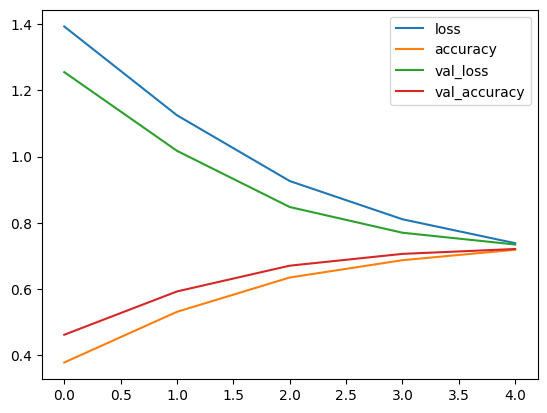

In [100]:
pd.DataFrame(model_3_history.history).plot()

In [101]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7349 - accuracy: 0.7213


[0.7348625063896179, 0.7213358879089355]

In [102]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 8s 8ms/step


array([[2.7415910e-01, 6.2352765e-01, 1.0196521e-02, 7.6832861e-02,
        1.5283867e-02],
       [2.2551696e-01, 6.1440927e-01, 1.7538013e-02, 7.8349188e-02,
        6.4186573e-02],
       [3.8392156e-01, 5.9127696e-03, 1.8543456e-02, 5.9126455e-01,
        3.5762807e-04],
       ...,
       [6.1825296e-04, 1.3117449e-02, 4.7669206e-03, 2.7984875e-04,
        9.8121750e-01],
       [3.6862022e-03, 2.1236402e-01, 5.1015243e-03, 2.2895609e-03,
        7.7655876e-01],
       [5.9596144e-02, 7.8615034e-01, 6.8520941e-03, 1.6352303e-02,
        1.3104916e-01]], dtype=float32)

In [104]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [105]:
# Calculate model results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_3_preds)

In [107]:
model_3_results

{'accuracy': 72.133589302264,
 'precision': 0.7233775593410275,
 'recall': 0.72133589302264,
 'f1': 0.715516726408535}

# Model 4: Combining pretrained token embeddings + character embeddings

![Image](img/character_token__embedding.png)


* Steps to Build the model
    1. Create a token-level model 
    2. Create a character-level model 
    3. Combine (using [`layers.Concatenate`]
    4. Build a series of output layers on top of 3 similar to Figure 1 and section 
    5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

## Choosing the Number of Units in BiLSTM: Multiples of 8

When designing Bidirectional Long Short-Term Memory (BiLSTM) layers for a neural network, selecting an appropriate number of units is a crucial decision. A common practice is to choose a number of units that is a multiple of 8. Here's the rationale behind this choice:

### Computational Efficiency:

Many modern hardware architectures, including GPUs, are optimized for parallel processing, and they often perform more efficiently when the number of processing units aligns with their architecture. Choosing a multiple of 8 for the number of units in a BiLSTM layer can enhance computational efficiency and leverage the parallelization capabilities of these hardware platforms.

### Memory Alignment:

Certain hardware architectures benefit from memory alignment when working with data structures. Aligning the number of units in a BiLSTM layer to a multiple of 8 can enhance memory access patterns, leading to more efficient data processing and reduced memory access latency.

### Practical Considerations:

While aligning with hardware characteristics is a consideration, the choice of the number of units should also be guided by the complexity of the task, the size of the dataset, and empirical experimentation. It's essential to strike a balance between computational efficiency and model performance based on the specific requirements of the problem at hand.

### Example in TensorFlow:

```python
from tensorflow.keras.layers import Bidirectional, LSTM

# Choose a number of units as a multiple of 8
num_units = 64  # Example: 8 * 8

# Define a Bidirectional LSTM layer
bilstm_layer = Bidirectional(LSTM(units=num_units, return_sequences=True))


In [109]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape = [], dtype = tf.string,
                           name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs = token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape = (1,), dtype = tf.string,
                          name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                           outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)

token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                   char_model.output])

# 4. Create output layers - addition of dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation = "relu")(combined_dropout)
final_output = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation = "softmax")(final_output)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                        outputs = output_layer,
                        name = "model_4_token_and_char_embeddings")

* Plot hybrid token and character model

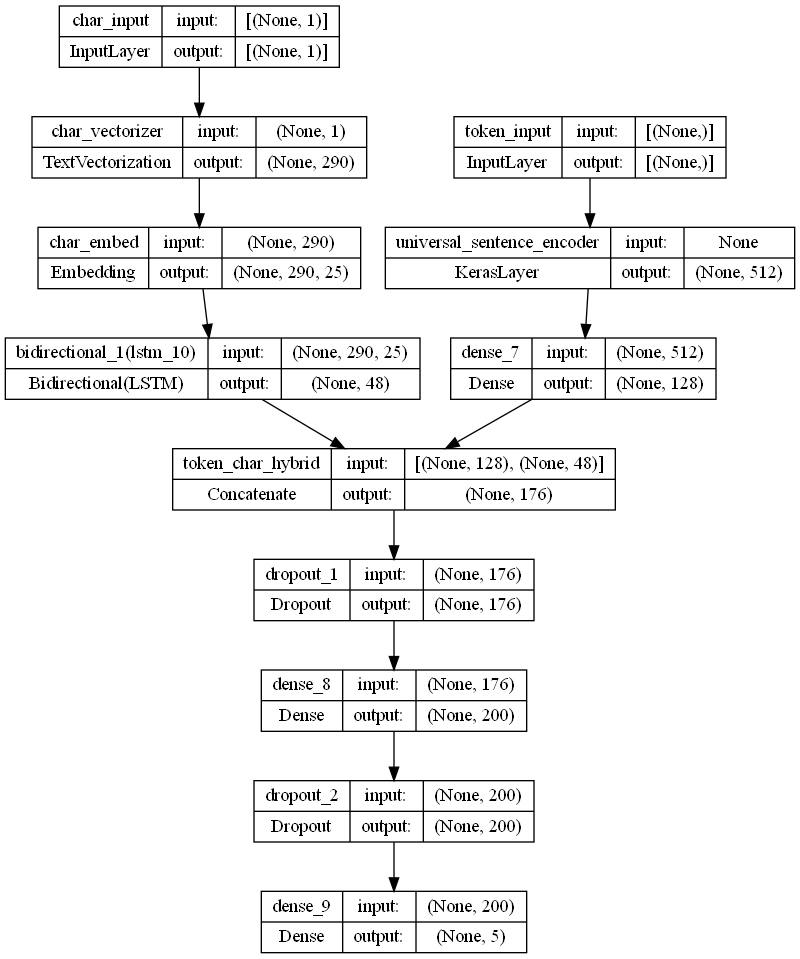

In [111]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [112]:
# Compile token char model
model_4.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

### Combining Token and Character Data into a Dataset

In natural language processing (NLP) tasks, combining both token-level and character-level information can enhance the robustness and effectiveness of machine learning models. This approach allows models to capture both semantic meaning at the token level and fine-grained details at the character level. Here's a guide on how to combine token and character data into a cohesive dataset:



In [113]:
# Combine chars and tokens into a dataset

# make data
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                           train_chars))
# make labels
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

# combine data
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,
                                               train_char_token_labels))


In [114]:
# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [115]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [117]:
# Display information about the training dataset with combined character and token embeddings
print("Training Character and Token Embedding Dataset:")
print(train_char_token_dataset)

# Display information about the validation dataset with combined character and token embeddings
print("\nValidation Character and Token Embedding Dataset:")
print(val_char_token_dataset)


Training Character and Token Embedding Dataset:
<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Validation Character and Token Embedding Dataset:
<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [118]:
# Fit the model on tokens and chars

model_4_history = model_4.fit(train_char_token_dataset,
                             epochs = 5,
                             validation_data = val_char_token_dataset)

Epoch 1/5
5627/5627 [==============================] - 283s 49ms/step - loss: 0.7552 - accuracy: 0.7112 - val_loss: 0.6295 - val_accuracy: 0.7599
Epoch 2/5
5627/5627 [==============================] - 275s 49ms/step - loss: 0.6736 - accuracy: 0.7467 - val_loss: 0.6010 - val_accuracy: 0.7721
Epoch 3/5
5627/5627 [==============================] - 280s 50ms/step - loss: 0.6499 - accuracy: 0.7549 - val_loss: 0.5876 - val_accuracy: 0.7761
Epoch 4/5
5627/5627 [==============================] - 285s 51ms/step - loss: 0.6363 - accuracy: 0.7605 - val_loss: 0.5737 - val_accuracy: 0.7814
Epoch 5/5
5627/5627 [==============================] - 296s 53ms/step - loss: 0.6255 - accuracy: 0.7642 - val_loss: 0.5655 - val_accuracy: 0.7858


<Axes: >

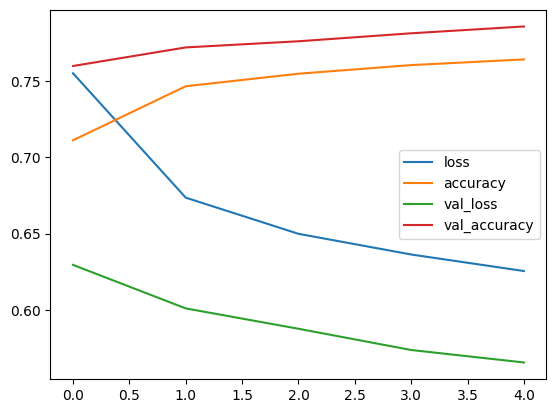

In [127]:
pd.DataFrame(model_4_history.history).plot()

In [119]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 28s 29ms/step - loss: 0.5655 - accuracy: 0.7858


[0.5655189156532288, 0.7858467102050781]

In [120]:
# Make predictions using token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 26s 27ms/step


array([[5.01326859e-01, 2.99624205e-01, 1.19556440e-03, 1.93511665e-01,
        4.34172293e-03],
       [4.25097078e-01, 4.31772232e-01, 3.86874285e-03, 1.36786625e-01,
        2.47537647e-03],
       [5.11227310e-01, 6.46116561e-04, 1.17335403e-02, 4.75972295e-01,
        4.20659839e-04],
       ...,
       [1.41671744e-05, 1.00842786e-04, 1.57699466e-03, 1.86734314e-06,
        9.98306155e-01],
       [2.04652287e-02, 8.91778991e-02, 9.84974727e-02, 4.85293381e-03,
        7.87006497e-01],
       [1.22853750e-02, 9.86140013e-01, 1.01066125e-03, 2.28788558e-04,
        3.35212593e-04]], dtype=float32)

In [125]:
# Turn prediction probabiblities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1], dtype=int64)>

In [126]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 78.5846683437045,
 'precision': 0.7845833430733352,
 'recall': 0.7858466834370449,
 'f1': 0.7823645457417082}

# Model 5: ANN model for sequential sentence classification

## Understanding Abstract Structure with Positional Embeddings

Abstracts typically follow a structured order, often organized around key sections, including:

- **Objective:**
  - Clearly states the goal or purpose of the study.

- **Background:**
  - Provides context and relevant information preceding the research.

- **Methods:**
  - Describes the methodology or approach used in the study.

- **Results:**
  - Presents the findings or outcomes of the research.

- **Conclusions:**
  - Summarizes key insights and implications drawn from the study.

These sections are conventionally organized in a sequential manner, forming a coherent narrative. For instance, a common order might be:

1. `OBJECTIVE`
2. `BACKGROUND`
3. `METHODS`
4. `RESULTS`
5. `CONCLUSIONS`

or variations like:

1. `BACKGROUND`
2. `OBJECTIVE`
3. `METHODS`
4. `RESULTS`
5. `CONCLUSIONS`

The role of positional embeddings becomes crucial in encoding this sequential structure. Positional embeddings enable the model to understand the inherent order of sections within an abstract, even when presented in various sequences. This capability is valuable not only during training but also extends to test time, ensuring consistent and accurate comprehension of the abstract's organizational structure.


In [128]:
# Inspecting training dataframe
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


## Create positional embeddings

In [129]:
# How many different line numbers are there ?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

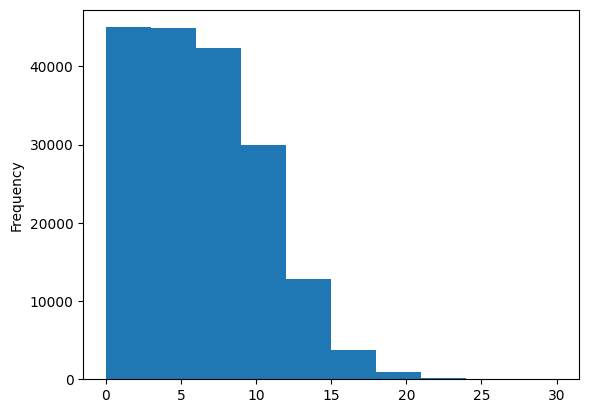

In [130]:
# Check the distribution of "line_number"
train_df.line_number.plot.hist()

* The majority of lines have a position of 15 or less, with this information
we will set the depth parameter to 15

In [131]:
# Create one-hot-encoded tensors 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),
                                       depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),
                                     depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),
                                      depth = 15)

Setting the `depth` parameter of `tf.one_hot` to 15 means any sample with a `"line_number"` value of over 15 gets set to a tensor of all 0's, where as any sample with a `"line_number"` of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the `"line_number"` value.

In [132]:
# Check one-hot encoded "line_number"
train_line_numbers_one_hot.shape

TensorShape([180040, 15])

In [133]:
train_line_numbers_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

* we are gona do samething as line_number for total_lines

In [134]:
# How many different numbers of lines are there ?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

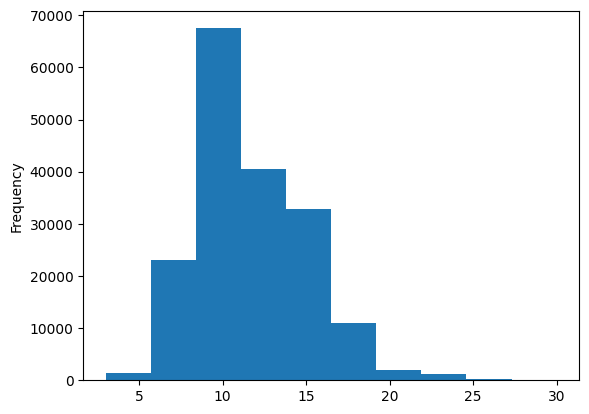

In [135]:
# Check the distribution of total lines
train_df.total_lines.plot.hist()

Looking at the distribution of our `"total_lines"` column, a value of 20 looks like it covers the majority of samples.

In [136]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Building a tribrid embedding model

1. Create a token-level model 
2. Create a character-level model 
3. Create a `"line_number"` model 
4. Create a `"total_lines"` model 
5. Combine  the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding 
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a [`tf.keras.Model`]

In [138]:
# Step 1. Token inputs

token_inputs = layers.Input(shape = [], dtype = "string",
                           name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs = token_outputs)

# Step 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = "string",
                          name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(units = 24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                           outputs = char_bi_lstm)

# Step 3. Line numbers inputs
line_number_inputs = layers.Input(shape = (15,), dtype = tf.int32,
                                 name = 'line_number_inputs')
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                  outputs = x)

# Step 4. Total lines inputs
total_line_inputs = layers.Input(shape = (20,), dtype = tf.int32,
                                name = "total_lines_inputs")
y = layers.Dense(32, activation = "relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs = total_line_inputs,
                                 outputs = y)

# Step 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name = "token_char_hybrid_embedding")([token_model.output,
                                                                               char_model.output])

z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Step 6. Combine positional embeddings with combined token and char embedding
z = layers.Concatenate(name = "token_char_positional_embedding")([line_number_model.output,
                                                                 total_line_model.output,
                                                                 z])
# Step 7. Create output layer
output_layer = layers.Dense(5, activation = "softmax",
                           name = "output_layer")(z)

# Step 8. Put all together
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                  total_line_model.input,
                                  token_model.input,
                                  char_model.input],
                        outputs = output_layer)

* Plot the Tribrid model

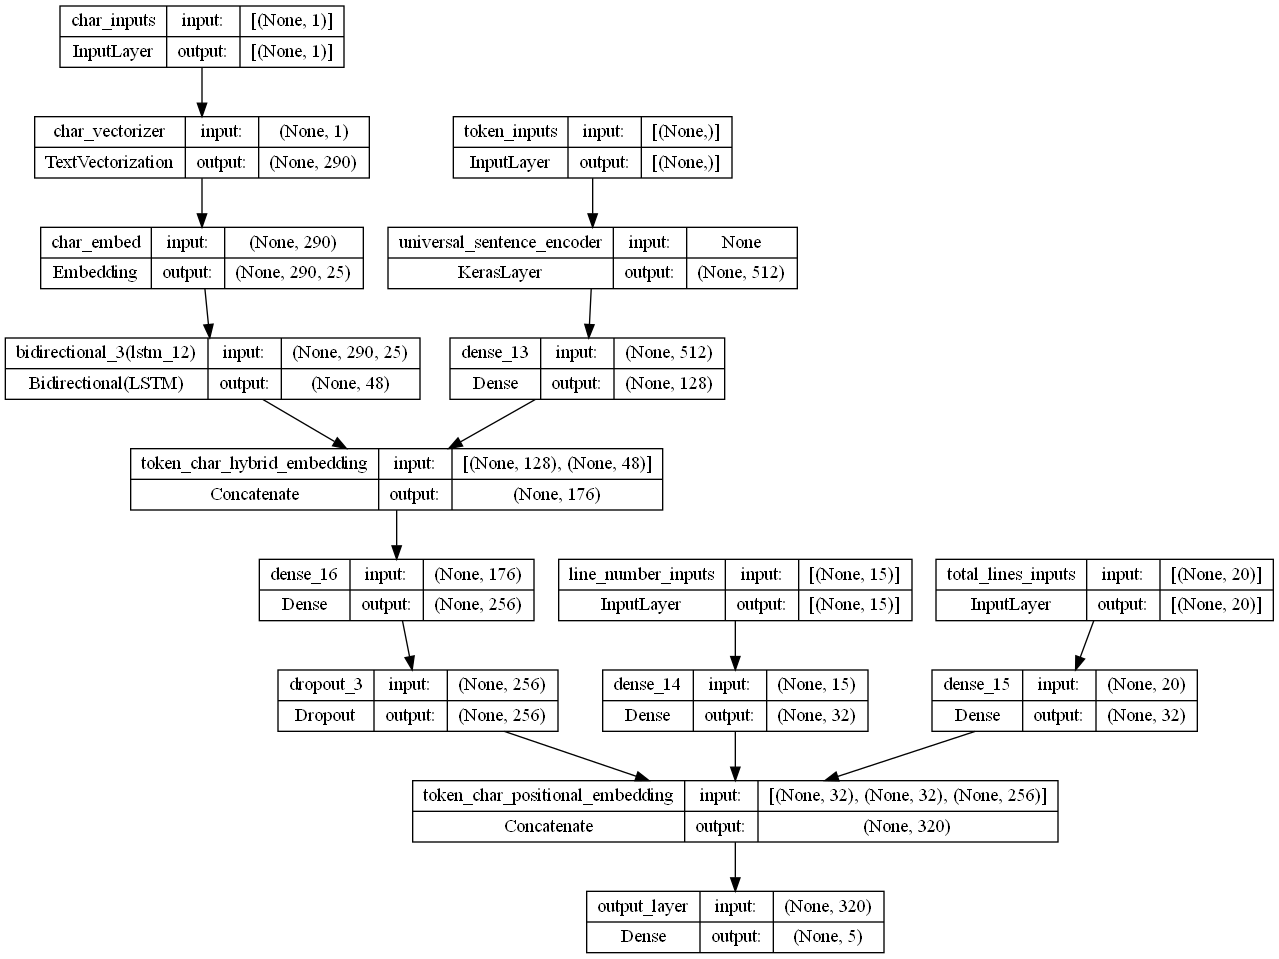

In [140]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes = True)

## Understanding Label Smoothing in Neural Networks

Label Smoothing is a regularization technique commonly used in neural networks, especially in classification tasks, to improve the generalization and robustness of the model. The primary goal of label smoothing is to prevent the model from becoming overconfident and overly reliant on training data, thereby enhancing its ability to handle unseen or uncertain instances.

### Purpose of Label Smoothing:

1. **Avoiding Overfitting:**
   - Label Smoothing helps mitigate the risk of overfitting, where a model memorizes the training data but fails to generalize well to new, unseen examples.

2. **Enhancing Robustness:**
   - By introducing a degree of uncertainty into the training labels, label smoothing encourages the model to be less certain about its predictions, making it more robust to noise and variations in the data.

### Mathematical Formulation:

The label smoothing mechanism adjusts the target labels by blending them with a uniform distribution. For a given true label \(y_i\) and the adjusted label \(y'_i\), the formula is:

$$ y'_i = (1 - \epsilon) \cdot y_i + \frac{\epsilon}{K} $$

where:
- $\epsilon$ is the label smoothing parameter, typically a small positive value.
- \(K\) is the number of classes.

### Implementation in TensorFlow:

In TensorFlow, label smoothing can be applied using a custom loss function or directly within the model's training loop. Here's a simplified example:

```python
import tensorflow as tf

def label_smoothed_loss(y_true, y_pred, epsilon=0.1):
    K = tf.shape(y_true)[-1]
    y_smoothed = (1.0 - epsilon) * y_true + epsilon / tf.cast(K, dtype=tf.float32)
    return tf.keras.losses.categorical_crossentropy(y_smoothed, y_pred)

# Example usage in a model
model.compile(optimizer='adam', loss=label_smoothed_loss, metrics=['accuracy'])


In [141]:
# Compile the model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

## Create a tribrid embedding datasets 

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)


In [142]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [143]:
# Fit the model
model_5_history = model_5.fit(train_pos_char_token_dataset,
                             epochs = 10,
                             validation_data = val_pos_char_token_dataset)

Epoch 1/10
5627/5627 [==============================] - 289s 51ms/step - loss: 0.9533 - accuracy: 0.8236 - val_loss: 0.9078 - val_accuracy: 0.8489
Epoch 2/10
5627/5627 [==============================] - 282s 50ms/step - loss: 0.9088 - accuracy: 0.8541 - val_loss: 0.8980 - val_accuracy: 0.8552
Epoch 3/10
5627/5627 [==============================] - 280s 50ms/step - loss: 0.8963 - accuracy: 0.8636 - val_loss: 0.8951 - val_accuracy: 0.8572
Epoch 4/10
5627/5627 [==============================] - 282s 50ms/step - loss: 0.8878 - accuracy: 0.8695 - val_loss: 0.8963 - val_accuracy: 0.8563
Epoch 5/10
5627/5627 [==============================] - 282s 50ms/step - loss: 0.8807 - accuracy: 0.8750 - val_loss: 0.8964 - val_accuracy: 0.8561
Epoch 6/10
5627/5627 [==============================] - 282s 50ms/step - loss: 0.8754 - accuracy: 0.8788 - val_loss: 0.8924 - val_accuracy: 0.8601
Epoch 7/10
5627/5627 [==============================] - 282s 50ms/step - loss: 0.8708 - accuracy: 0.8828 - val_loss: 0

<Axes: >

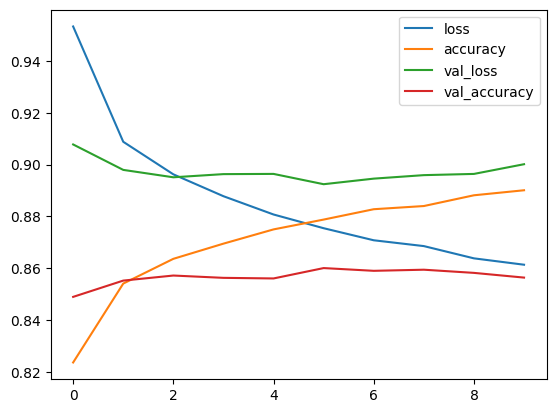

In [144]:
pd.DataFrame(model_5_history.history).plot()

In [145]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 27s 28ms/step


array([[0.58359545, 0.08434473, 0.03468012, 0.27074444, 0.02663533],
       [0.5509992 , 0.10060535, 0.0718912 , 0.25559345, 0.02091075],
       [0.28413564, 0.06818485, 0.02429014, 0.58120495, 0.04218436],
       ...,
       [0.02489461, 0.07734222, 0.01697423, 0.03378055, 0.84700835],
       [0.02509947, 0.7458454 , 0.04070122, 0.0222185 , 0.16613546],
       [0.05437759, 0.88165194, 0.0241868 , 0.0252044 , 0.01457916]],
      dtype=float32)

In [146]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [147]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.6381570236992,
 'precision': 0.8585489589118434,
 'recall': 0.8563815702369919,
 'f1': 0.8538276595137048}

In [149]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({
                                  "custom_token_embed": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
custom_token_embed,79.782868,0.797397,0.797829,0.797035
pretrained_token_embed,77.217662,0.770709,0.772177,0.768106
custom_char_embed,72.133589,0.723378,0.721336,0.715517
hybrid_char_token_embed,78.584668,0.784583,0.785847,0.782365
tribrid_pos_char_token_embed,85.638157,0.858549,0.856382,0.853828


## Model Performance Metrics

Here are the performance metrics for different models on a classification task. The metrics include accuracy, precision, recall, and F1 score. Each model is named based on its embedding strategy.

| Model Name                     | Accuracy | Precision | Recall  | F1 Score |
| ------------------------------ | -------- | --------- | ------- | -------- |
| **custom_token_embed**         | 79.78%   | 79.74%    | 79.78%  | 79.70%   |
| **pretrained_token_embed**     | 77.22%   | 77.07%    | 77.22%  | 76.81%   |
| **custom_char_embed**          | 72.13%   | 72.34%    | 72.13%  | 71.55%   |
| **hybrid_char_token_embed**    | 78.58%   | 78.46%    | 78.58%  | 78.24%   |
| **tribrid_pos_char_token_embed**| 85.64%  | 85.85%    | 85.64%  | 85.38%   |

### Interpretation:

1. **custom_token_embed:**
   - Utilizes custom token embeddings.
   - Achieves balanced performance across accuracy, precision, recall, and F1 score.

2. **pretrained_token_embed:**
   - Uses pretrained token embeddings, potentially from language models.
   - Slightly lower accuracy compared to the custom token embeddings.

3. **custom_char_embed:**
   - Incorporates custom character embeddings.
   - Lower accuracy compared to token-based approaches.

4. **hybrid_char_token_embed:**
   - Combines character and token embeddings in a hybrid approach.
   - Balanced performance with competitive accuracy and F1 score.

5. **tribrid_pos_char_token_embed:**
   - Integrates positional, character, and token embeddings in a tribrid approach.
   - Demonstrates the highest overall performance with the highest accuracy, precision, recall, and F1 score.

These metrics provide insights into the effectiveness of different embedding strategies, helping in the selection of the most suitable model based on the specific goals and requirements of the classification task.


## Evaluation of the Tribrid Model

The tribrid_pos_char_token_embed model has demonstrated commendable performance, achieving high F1-score, recall, and precision. However, it's crucial to address the observation of a relatively high loss, indicating a potential issue of overfitting.

### Performance Metrics:

- **F1-score:** Achieved a strong F1-score, indicating a good balance between precision and recall.
- **Recall:** Demonstrated high recall, showcasing the model's ability to capture a significant portion of true positive instances.
- **Precision:** Exhibited high precision, emphasizing the accuracy of positive predictions among instances classified as positive.

### Concern: High Loss and Potential Overfitting

- **Loss:** The observed high loss suggests that the model may be fitting too closely to the training data, potentially compromising its ability to generalize to new, unseen data.

### Mitigation Strategy:

To address the potential overfitting issue, consider implementing the following strategies:

1. **Regularization Techniques:**
   - Introduce dropout layers within the model architecture to randomly deactivate a fraction of neurons during training, preventing overreliance on specific features.

2. **Adjust Model Complexity:**
   - Evaluate if the model architecture is overly complex for the given task. Reducing the number of layers or neurons may help mitigate overfitting.

3. **Data Augmentation:**
   - Augment the training dataset by applying random transformations to the input data, introducing variability and improving the model's ability to generalize.

4. **Early Stopping:**
   - Implement early stopping during training to halt the training process when the model's performance on a validation set starts to degrade, preventing overfitting.

5. **Hyperparameter Tuning:**
   - Experiment with different hyperparameter configurations, such as learning rates or batch sizes, to find values that enhance generalization.

By implementing these strategies, you can enhance the robustness of the model, mitigate overfitting, and improve its ability to perform well on unseen data.


## Identifying Potential Overfitting in the Tribrid Model

Our tribrid model is performing well, but it's essential to pinpoint any potential overfitting within its components. Let's explore and identify which specific part of the model might be susceptible to overfitting.

### Evaluation Steps:

1. **Analyzing Loss Curves:**
   - Examine the training and validation loss curves for each component of the tribrid model.
   - A significant gap between the training and validation loss curves may indicate overfitting.

2. **Inspecting Training Metrics:**
   - Evaluate the training accuracy, precision, recall, and F1-score for each part of the tribrid model.
   - High training metrics without corresponding improvements on the validation set can be indicative of overfitting.


By thoroughly analyzing these aspects, we can make informed adjustments to enhance the tribrid model's ability to generalize and perform well on unseen data.


In [179]:
import matplotlib.pyplot as plt

def plot_training_history(histories, metric='accuracy', title='Model Training History'):
    plt.figure(figsize=(12, 8))

    for i, history in enumerate(histories):
        plt.plot(history[metric], label=f'Model {i + 1} - Training')
        plt.plot(history[f'val_{metric}'], label=f'Model {i + 1} - Validation')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

In [186]:
histories = [
            model_2_history.history,
            model_3_history.history,
            model_4_history.history,
            model_5_history.history]
histories

[{'loss': [0.7632833123207092,
   0.6653537154197693,
   0.6325005292892456,
   0.6099804043769836,
   0.5920596718788147],
  'accuracy': [0.7065874338150024,
   0.7465507388114929,
   0.7594534754753113,
   0.7680237889289856,
   0.7751666307449341],
  'val_loss': [0.6854707598686218,
   0.6448532938957214,
   0.6235858201980591,
   0.6091631054878235,
   0.5991312861442566],
  'val_accuracy': [0.7386800050735474,
   0.7542036175727844,
   0.7627432942390442,
   0.7677744030952454,
   0.7721766233444214]},
 {'loss': [1.3928638696670532,
   1.1248539686203003,
   0.9264389276504517,
   0.8110565543174744,
   0.7388508915901184],
  'accuracy': [0.3788546919822693,
   0.5317984819412231,
   0.6352477073669434,
   0.6875749826431274,
   0.7190402150154114],
  'val_loss': [1.2551428079605103,
   1.017549991607666,
   0.8480076193809509,
   0.7704429030418396,
   0.7348625063896179],
  'val_accuracy': [0.4625645577907562,
   0.5932410955429077,
   0.6709916591644287,
   0.7066066265106201,


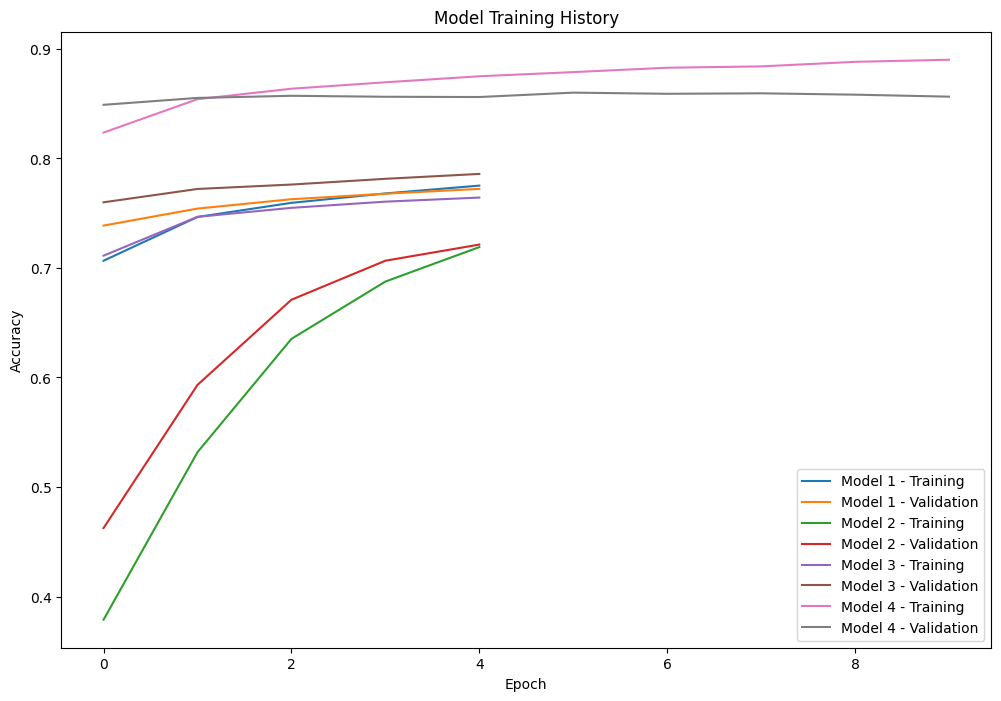

In [187]:
plot_training_history(histories, metric = "accuracy")

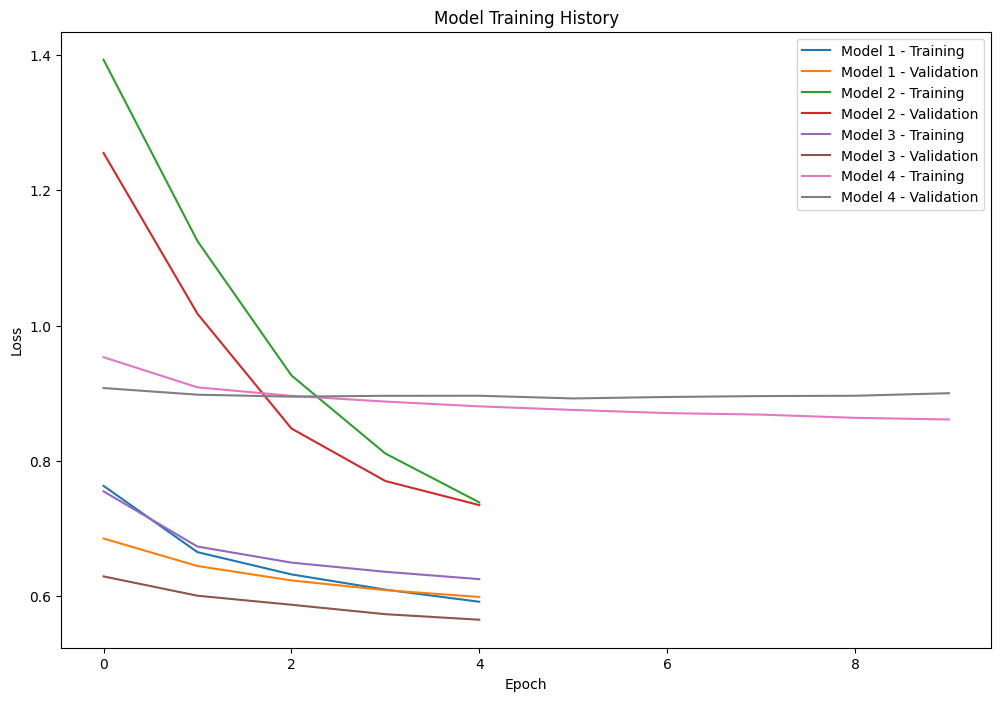

In [188]:
plot_training_history(histories, metric = "loss")

* Upon analyzing these two plots, we can confidently conclude that there is no discernible potential for overfitting.

## Save and load best performing model

In [193]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets
